# Scalable Spectral Clustering via Nystrom Approximation: From Synthetic Manifolds to Image Segmentation

### Import libraries and Datasets

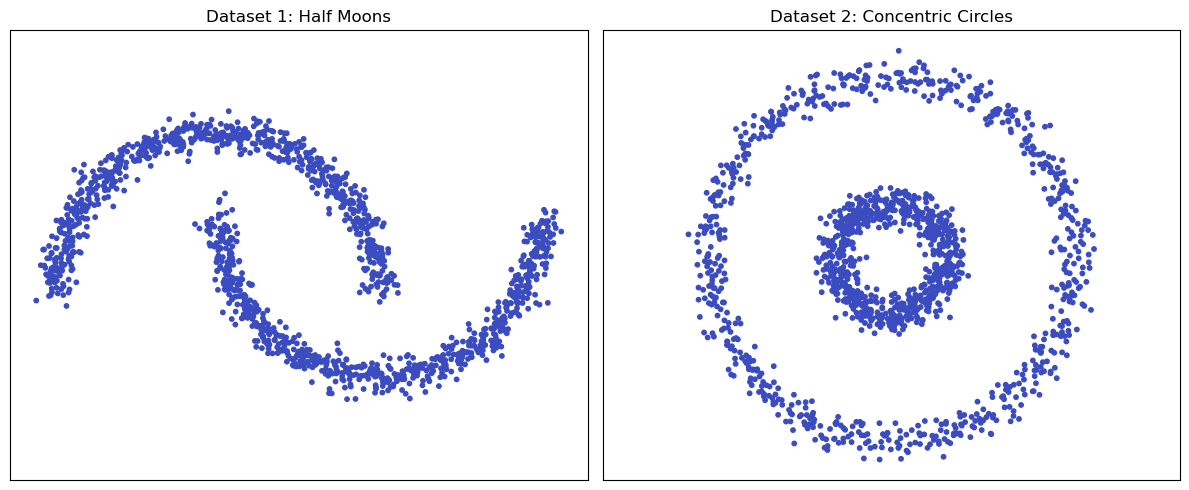

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_moons, make_circles
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, adjusted_rand_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from skimage import data
from skimage.transform import rescale
from skimage.filters import gaussian  

n_samples = 1500
random_state = 42

X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.3, noise=0.05, random_state=random_state)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='coolwarm')
    plt.title(title)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, np.zeros(n_samples), "Dataset 1: Half Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, np.zeros(n_samples), "Dataset 2: Concentric Circles")
plt.tight_layout()
plt.show()

### K-Means Limitations

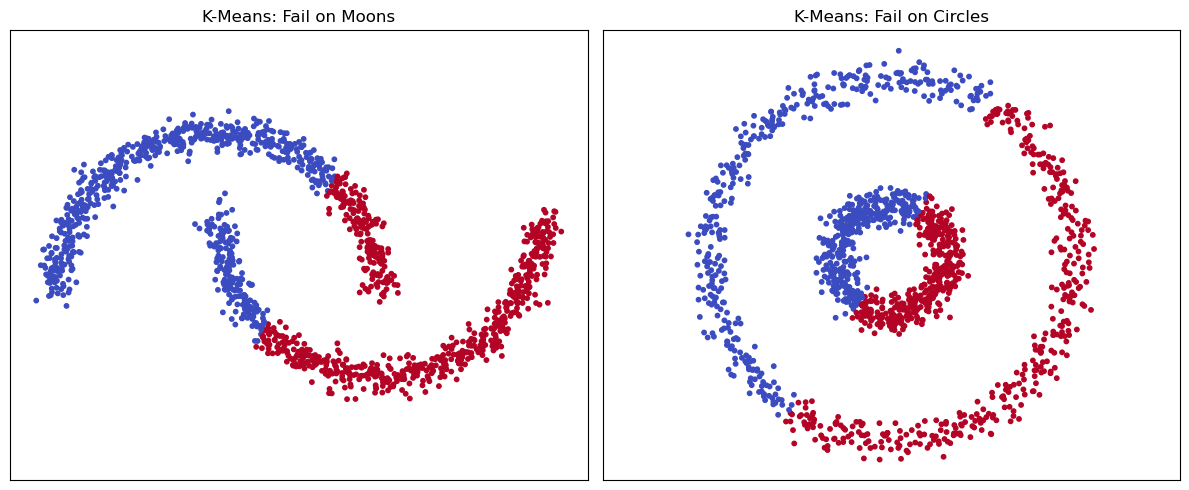

In [2]:
kmeans_moons = KMeans(n_clusters=2, random_state=random_state).fit(X_moons)
kmeans_circles = KMeans(n_clusters=2, random_state=random_state).fit(X_circles)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, kmeans_moons.labels_, "K-Means: Fail on Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, kmeans_circles.labels_, "K-Means: Fail on Circles")
plt.tight_layout()
plt.show()


## DBSCAN from scratch

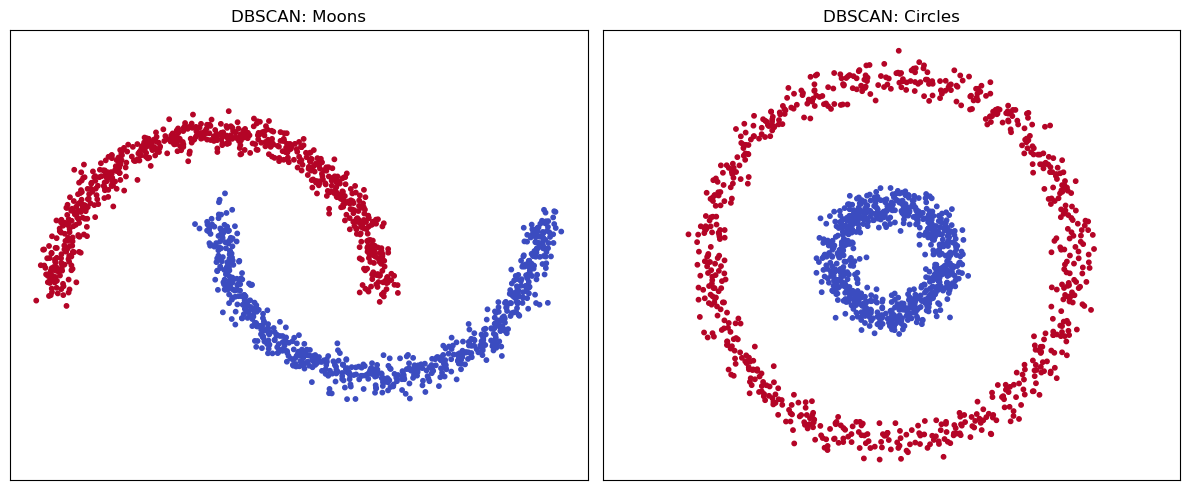

In [3]:
def dbscan(X, eps, min_samples):
    n = X.shape[0]
    labels = np.full(n, -1)  
    cluster_id = 0
    distances = pairwise_distances(X)
    visited = np.zeros(n, dtype=bool)

    def region_query(point_idx):
        return np.where(distances[point_idx] <= eps)[0]

    def expand_cluster(point_idx, neighbors):
        nonlocal cluster_id
        labels[point_idx] = cluster_id

        i = 0
        while i < len(neighbors):
            neighbor = neighbors[i]
            if not visited[neighbor]:
                visited[neighbor] = True
                neighbor_neighbors = region_query(neighbor)
                if len(neighbor_neighbors) >= min_samples:
                    neighbors = np.concatenate((neighbors, neighbor_neighbors))
            if labels[neighbor] == -1:
                labels[neighbor] = cluster_id
            i += 1
    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        neighbors = region_query(i)
        if len(neighbors) < min_samples:
            labels[i] = -1  
        else:
            expand_cluster(i, neighbors)
            cluster_id += 1
    return labels

eps = 0.15
min_samples = 5

labels_moons = dbscan(X_moons, eps, min_samples)
labels_circles = dbscan(X_circles, eps, min_samples)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, labels_moons, "DBSCAN: Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, labels_circles, "DBSCAN: Circles")
plt.tight_layout()
plt.show()

## Spectral Clustering from scratch

--- Dataset: Circles ---


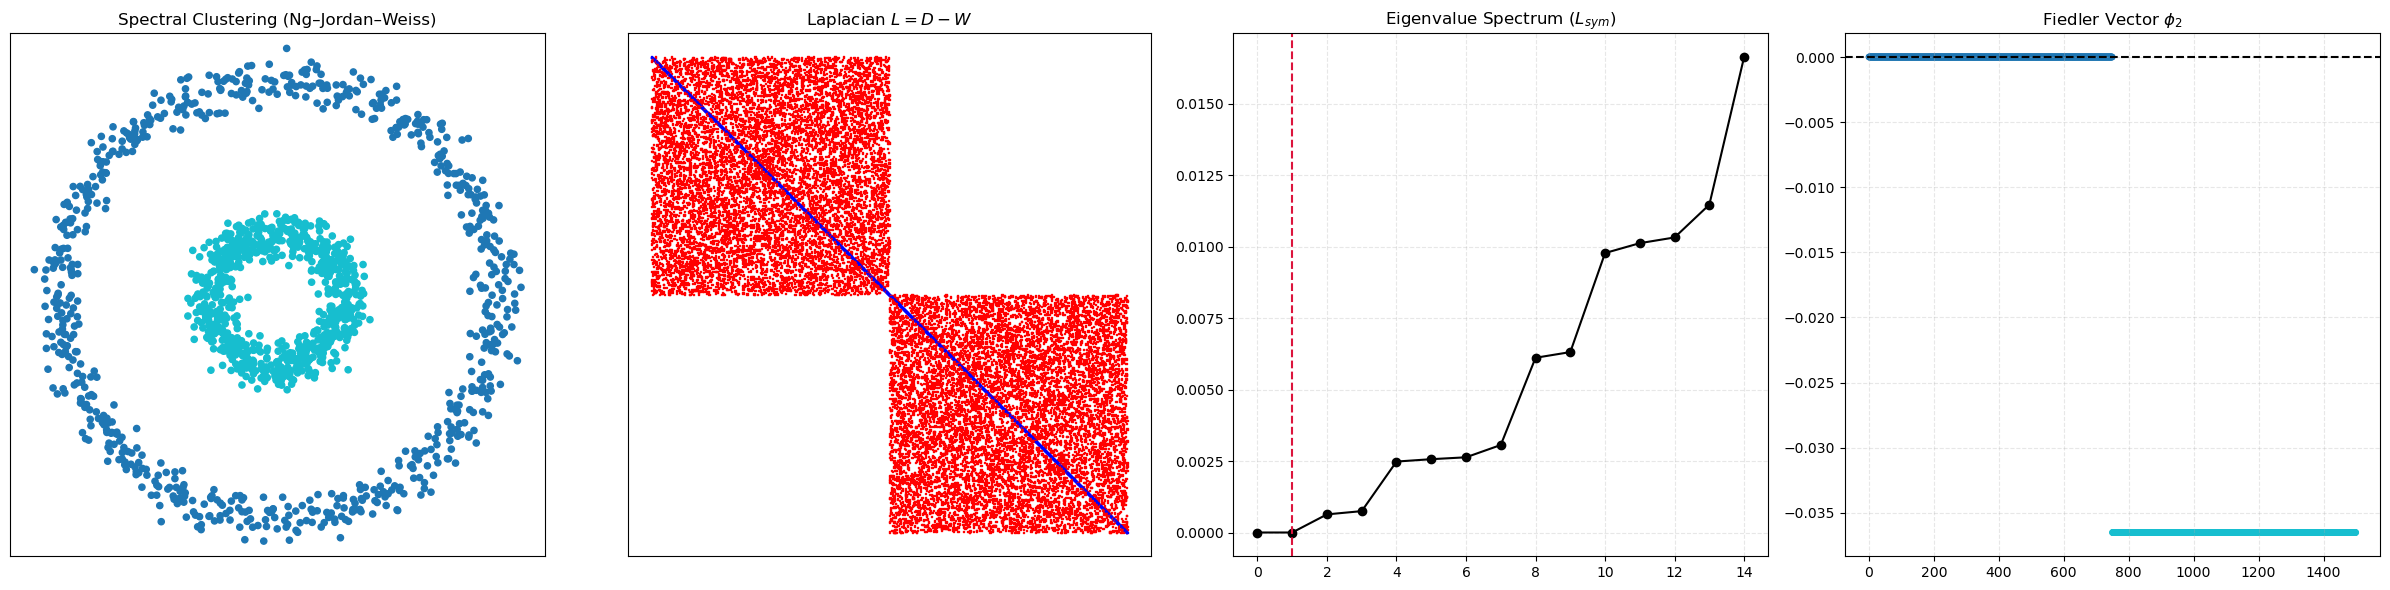

--- Dataset: Moons ---


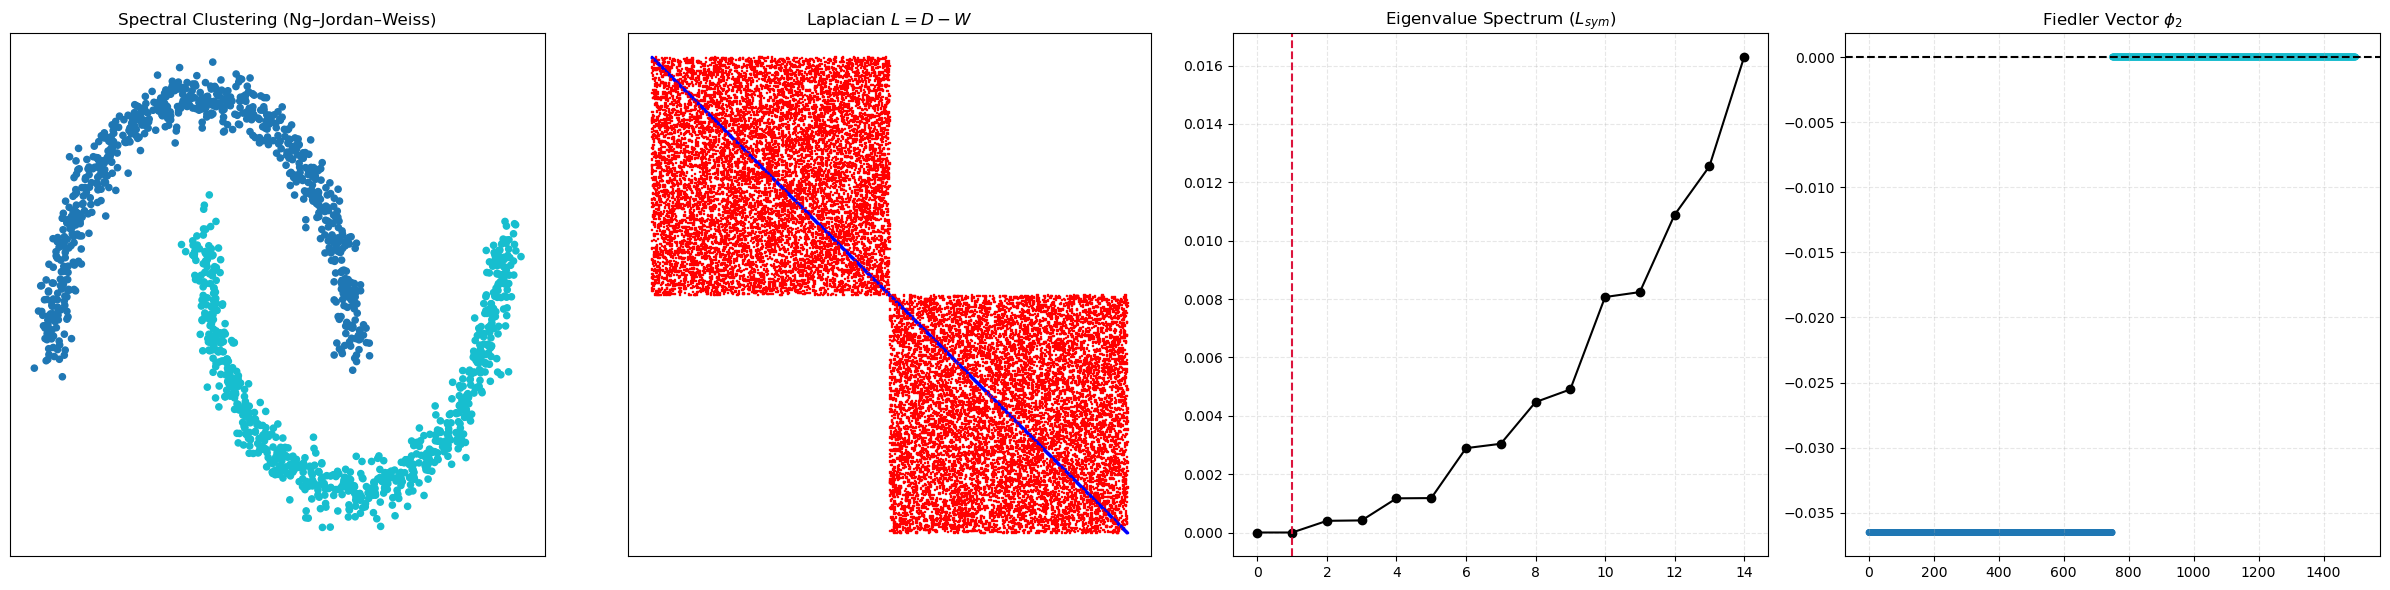

In [4]:
def spectral_clustering(X, n_clusters, sigma, k_nn, plot_results=True):
    N = X.shape[0]
    dists = pairwise_distances(X)
    W = np.exp(-dists**2 / (2 * sigma**2))

    knn_idx = np.argsort(dists, axis=1)[:, 1:k_nn+1]
    mask = np.zeros_like(W)
    for i in range(N):
        mask[i, knn_idx[i]] = 1

    W *= mask
    W = np.maximum(W, W.T)   
    np.fill_diagonal(W, 0)

    d = np.sum(W, axis=1)
    D = np.diag(d)
    L = D - W

    d_inv_sqrt = np.power(d, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    L_sym = np.eye(N) - D_inv_sqrt @ W @ D_inv_sqrt

    evals, evecs = np.linalg.eigh(L_sym)
    U = evecs[:, :n_clusters]
    U /= np.linalg.norm(U, axis=1, keepdims=True) + 1e-12

    labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(U)

    if plot_results:
        sort_idx = np.argsort(labels)
        evals_L, evecs_L = np.linalg.eigh(L)
        fiedler = evecs_L[:, 1]
        Ls = L[sort_idx][:, sort_idx]

        fig, ax = plt.subplots(1, 4, figsize=(24, 6))

        ax[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=20)
        ax[0].set_title("Spectral Clustering (Ng–Jordan–Weiss)")
        ax[0].axis('equal'); ax[0].set_xticks([]); ax[0].set_yticks([])

        r, c = np.where(np.abs(Ls) > 1e-12)
        v = Ls[r, c]
        col = ['red' if x < 0 else 'blue' for x in v]
        ax[1].scatter(c, r, c=col, s=1, marker='s')
        ax[1].set_title("Laplacian $L = D - W$")
        ax[1].set_aspect('equal')
        ax[1].invert_yaxis()
        ax[1].set_xticks([]); ax[1].set_yticks([])

        ax[2].plot(evals[:15], 'o-k')
        ax[2].axvline(n_clusters - 1, ls='--', c='crimson')
        ax[2].set_title("Eigenvalue Spectrum ($L_{sym}$)")
        ax[2].grid(alpha=0.3, ls='--')

        ax[3].scatter(range(N), fiedler[sort_idx],c=labels[sort_idx], cmap='tab10', s=15)
        ax[3].axhline(0, ls='--', c='k')
        ax[3].set_title(r"Fiedler Vector $\phi_2$")
        ax[3].grid(alpha=0.3, ls='--')

        plt.tight_layout()
        plt.show()

    return labels

scaler = StandardScaler()
X_moons_std = scaler.fit_transform(X_moons)
X_circles_std = scaler.fit_transform(X_circles)

print("--- Dataset: Circles ---")
_ = spectral_clustering(X_circles_std, 2, sigma=0.5, k_nn=10)

print("--- Dataset: Moons ---")
_ = spectral_clustering(X_moons_std, 2, sigma=0.5, k_nn=10)

## Nystrom method 

--- Dataset: Moons ---


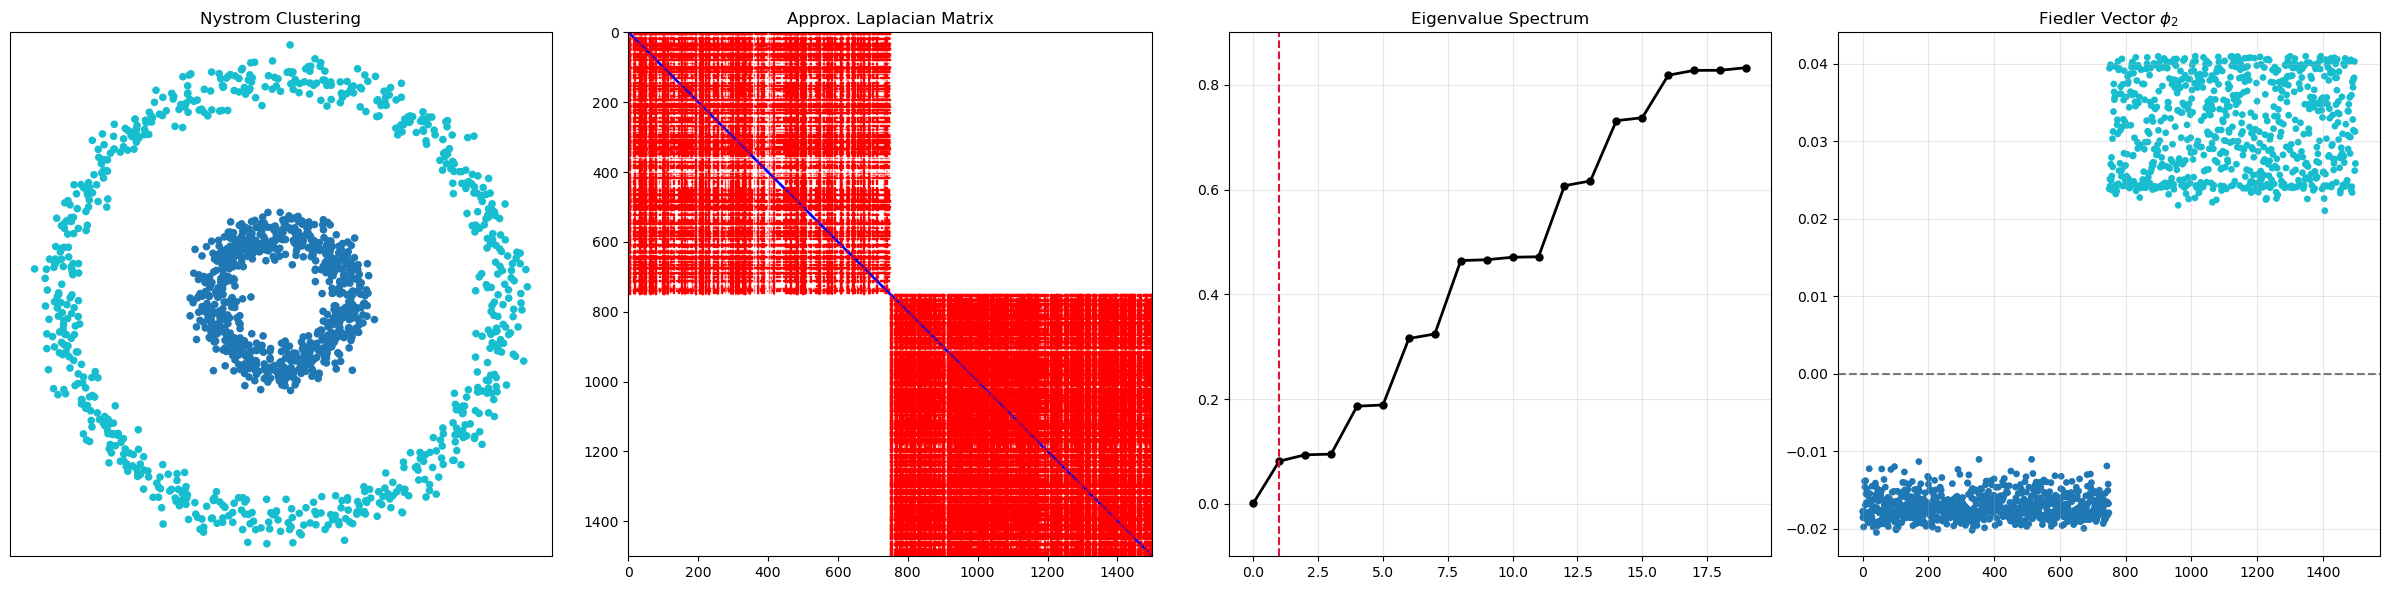

--- Dataset: Circles ---


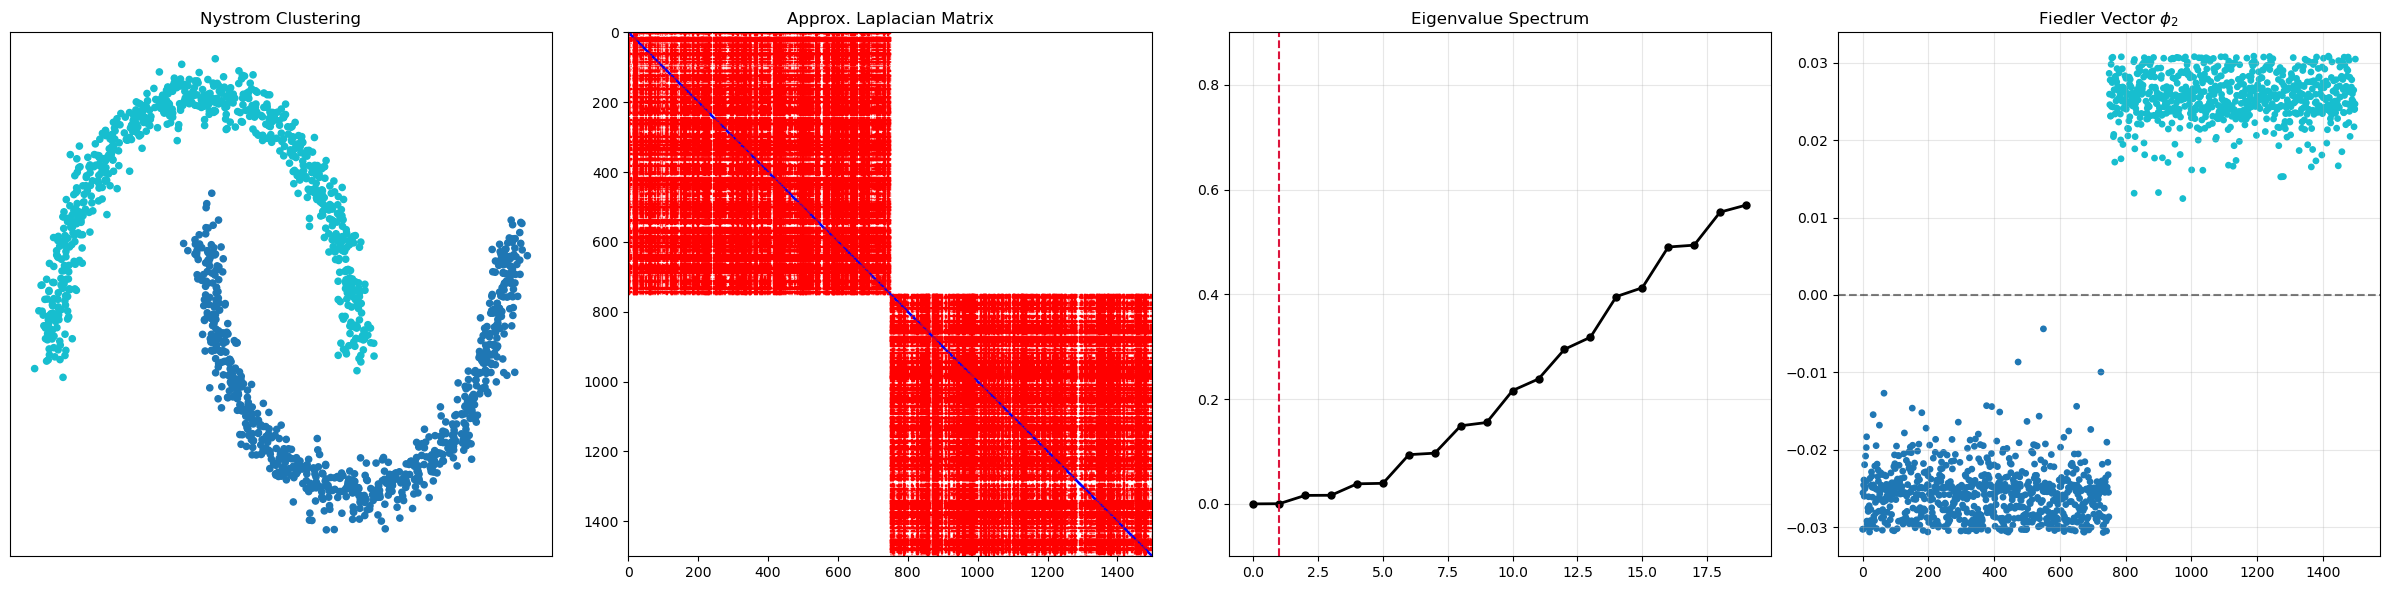

In [5]:
def nystrom_spectral_clustering(X, m, n_clusters, gamma=None):
    n = X.shape[0]
    if gamma is None:
        gamma = 1.0 / (2 * np.median(np.var(X, axis=0)))

    indices = np.random.choice(n, m, replace=False)
    mask = np.zeros(n, dtype=bool)
    mask[indices] = True
    
    X_sampled = X[mask]
    X_remaining = X[~mask]
    
    
    A = rbf_kernel(X_sampled, X_sampled, gamma=gamma)
    B = rbf_kernel(X_remaining, X_sampled, gamma=gamma)

    d = np.concatenate([
        np.sum(A, axis=1) + np.sum(B.T, axis=1),
        np.sum(B, axis=1) + B @ (np.linalg.pinv(A) @ np.sum(B.T, axis=1))
    ])
    d_inv_sqrt = 1.0 / np.sqrt(d + 1e-10)
    d_m = d_inv_sqrt[:m]
    d_nm = d_inv_sqrt[m:]
    
    A_norm = np.diag(d_m) @ A @ np.diag(d_m)
    B_norm = np.diag(d_nm) @ B @ np.diag(d_m)

    v_eigenvals, U = np.linalg.eigh(A_norm)
    v_eigenvals = np.maximum(v_eigenvals[::-1], 1e-10)
    U = U[:, ::-1]

    A_inv_sqrt = U @ np.diag(1.0 / np.sqrt(v_eigenvals)) @ U.T

    Q = A_norm + A_inv_sqrt @ (B_norm.T @ B_norm) @ A_inv_sqrt
    v_q, U_q = np.linalg.eigh(Q)
    v_q = np.maximum(v_q[::-1], 1e-10)
    U_q = U_q[:, ::-1]

    combined_AB_norm = np.zeros((n, m))
    combined_AB_norm[mask] = A_norm
    combined_AB_norm[~mask] = B_norm
    
    V_final = combined_AB_norm @ A_inv_sqrt @ U_q @ np.diag(1.0 / np.sqrt(v_q))

    V_k = V_final[:, :n_clusters] 
    
    row_norms = np.linalg.norm(V_k, axis=1, keepdims=True)
    
    V_normalized = np.nan_to_num(V_k / (row_norms + 1e-10))
    labels= KMeans(n_clusters=n_clusters, n_init=10).fit_predict(V_normalized)
    return labels, v_q,  V_final


def plot_nystrom_results(X, labels, v_q, V_final, n_clusters):
    n = X.shape[0]
    sort_idx = np.argsort(labels)
    laplacian_evals = np.sort(1.0 - v_q) 

    fig, ax = plt.subplots(1, 4, figsize=(24, 6))

    ax[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=20)
    ax[0].set_title("Nystrom Clustering")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].axis('equal')

    W_approx = V_final[:, :n_clusters] @ V_final[:, :n_clusters].T
    L_approx = np.eye(n) - W_approx
    L_sorted = L_approx[sort_idx][:, sort_idx]

    threshold = np.percentile(np.abs(L_sorted), 90) 
    rows, cols = np.where(np.abs(L_sorted) > threshold)
    vals = L_sorted[rows, cols]
    
    colors = ['red' if v < 0 else 'blue' for v in vals]
    ax[1].scatter(cols, rows, c=colors, s=0.2, marker='s')
    ax[1].set_xlim(0, n); 
    ax[1].set_ylim(n, 0)
    ax[1].set_aspect('equal')
    ax[1].set_title("Approx. Laplacian Matrix")

   
    ax[2].plot(laplacian_evals[:20], 'o-', color='black', linewidth=2, markersize=5)
    ax[2].axvline(x=n_clusters-1, color='crimson', linestyle='--')
    ax[2].set_title("Eigenvalue Spectrum")
    ax[2].grid(True, alpha=0.3)
    ax[2].set_ylim(-0.1, 0.9) 

  
    fiedler_vec = V_final[:, 1]
    ax[3].scatter(range(n), fiedler_vec[sort_idx], c=labels[sort_idx], cmap='tab10', s=15)
    ax[3].axhline(y=0, color='k', ls='--', alpha=0.5)
    ax[3].set_title(r"Fiedler Vector $\phi_2$")
    ax[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)
X_circles_scaled = scaler.fit_transform(X_circles)

labels_nystrom_moons, evals_moons, evects_moons = nystrom_spectral_clustering(X_moons_scaled, m=150, n_clusters=2, gamma=10.0)
labels_nystrom_circles, evals_circles, evects_circles = nystrom_spectral_clustering(X_circles_scaled, m=150, n_clusters=2, gamma=2.0)

print("--- Dataset: Moons ---")
plot_nystrom_results(X_circles_scaled, labels_nystrom_circles, evals_circles, evects_circles, n_clusters=2)

print("--- Dataset: Circles ---")
plot_nystrom_results(X_moons_scaled, labels_nystrom_moons, evals_moons, evects_moons, n_clusters=2)


### Spectral Clustering vs Nystrom Method comparison

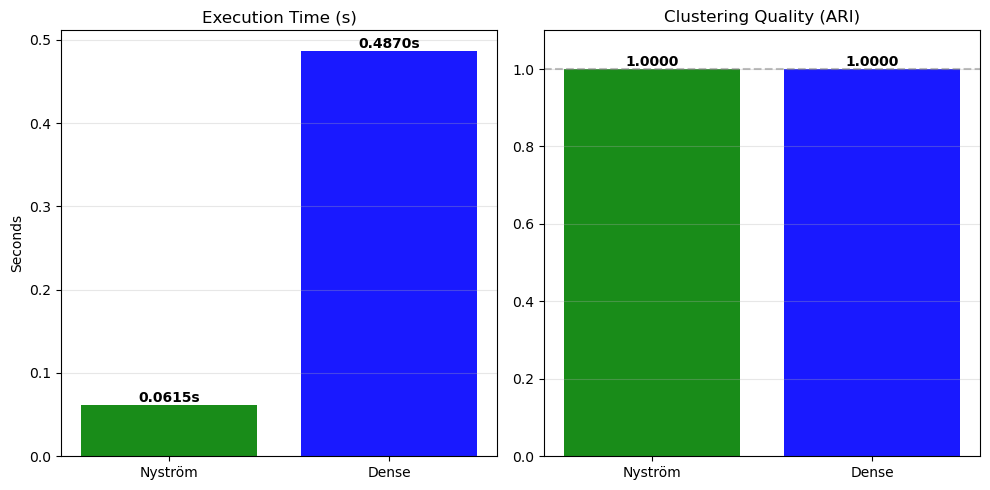

In [6]:
t0 = time.time()
labels_nys, _, _ = nystrom_spectral_clustering(X_circles_std, n_clusters=2, m=150, gamma=15.0)
t_nys = time.time() - t0
ari_nys = adjusted_rand_score(y_circles, labels_nys)

t0 = time.time()
labels_dense = spectral_clustering(X_circles_std, n_clusters=2, sigma=0.5, k_nn=10, plot_results=False)
t_dense = time.time() - t0
ari_dense = adjusted_rand_score(y_circles, labels_dense)

methods = ["Nyström", "Dense"]
times = [t_nys, t_dense]
aris = [ari_nys, ari_dense]
colors = ['green', 'blue']  

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

bars1 = axes[0].bar(methods, times, color=colors, alpha=0.9)
axes[0].set_title("Execution Time (s)")
axes[0].set_ylabel("Seconds")
axes[0].grid(axis="y", alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}s', ha='center', va='bottom', fontweight='bold')

bars2 = axes[1].bar(methods, aris, color=colors, alpha=0.9)
axes[1].set_title("Clustering Quality (ARI)")
axes[1].set_ylim(0, 1.1)
axes[1].axhline(1.0, color='gray', linestyle='--', alpha=0.5)
axes[1].grid(axis="y", alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Image Segmentation on a simple example (Spectral Clustering vs Nystrom Method)

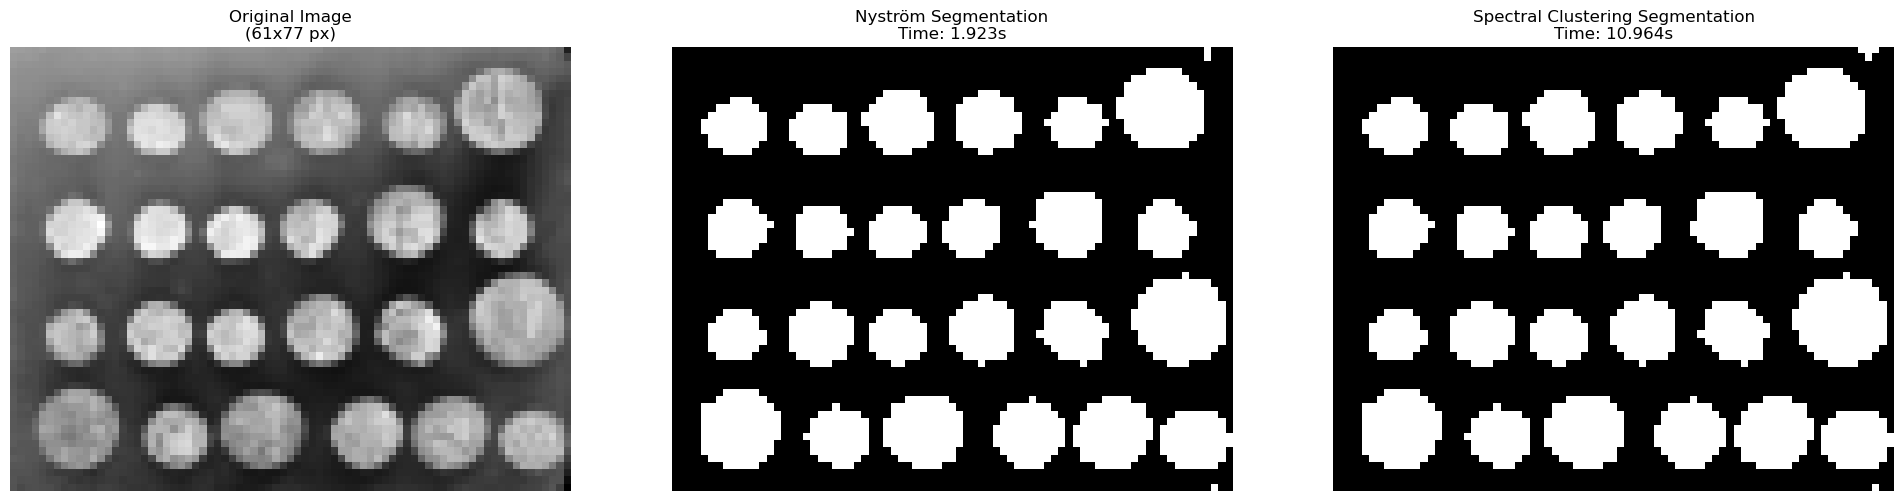

In [7]:
img = data.coins()
scale_factor = 0.20 
img_res = rescale(img, scale_factor, anti_aliasing=True)
rows, cols = img_res.shape

background = gaussian(img_res, sigma=15)
img_flat = img_res - background
img_flat = (img_flat - img_flat.min()) / (img_flat.max() - img_flat.min())

r_coords, c_coords = np.indices((rows, cols))
r_norm = r_coords.ravel() / rows
c_norm = c_coords.ravel() / cols
intensity = img_flat.ravel()  

weight_color = 10.0  
weight_space = 0.5   

X_features = np.column_stack([
    r_norm * weight_space, 
    c_norm * weight_space, 
    intensity * weight_color
])


t0_nys = time.time()
labels_nys, _, _ = nystrom_spectral_clustering(X_features, m=500, n_clusters=2, gamma=None)
t_nys = time.time() - t0_nys
segmentation_nys = labels_nys.reshape((rows, cols))

t0_dense = time.time()

labels_dense = spectral_clustering(X_features, n_clusters=2, sigma=0.1, k_nn=20, plot_results=False)
t_dense = time.time() - t0_dense
segmentation_dense = labels_dense.reshape((rows, cols))

if segmentation_dense[0, 0] == 1: segmentation_dense = 1 - segmentation_dense
if segmentation_nys[0, 0] == 1: segmentation_nys = 1 - segmentation_nys

fig, ax = plt.subplots(1, 3, figsize=(20, 5)) 

ax[0].imshow(img_res, cmap='gray')
ax[0].set_title(f"Original Image\n({rows}x{cols} px)")
ax[0].axis('off')

ax[1].imshow(segmentation_nys, cmap='gray')
ax[1].set_title(f"Nyström Segmentation\nTime: {t_nys:.3f}s")
ax[1].axis('off')

ax[2].imshow(segmentation_dense, cmap='gray')
ax[2].set_title(f"Spectral Clustering Segmentation\nTime: {t_dense:.3f}s")
ax[2].axis('off')

plt.tight_layout()
plt.show()


### Image segmentation on a real example (Nystrom Method)

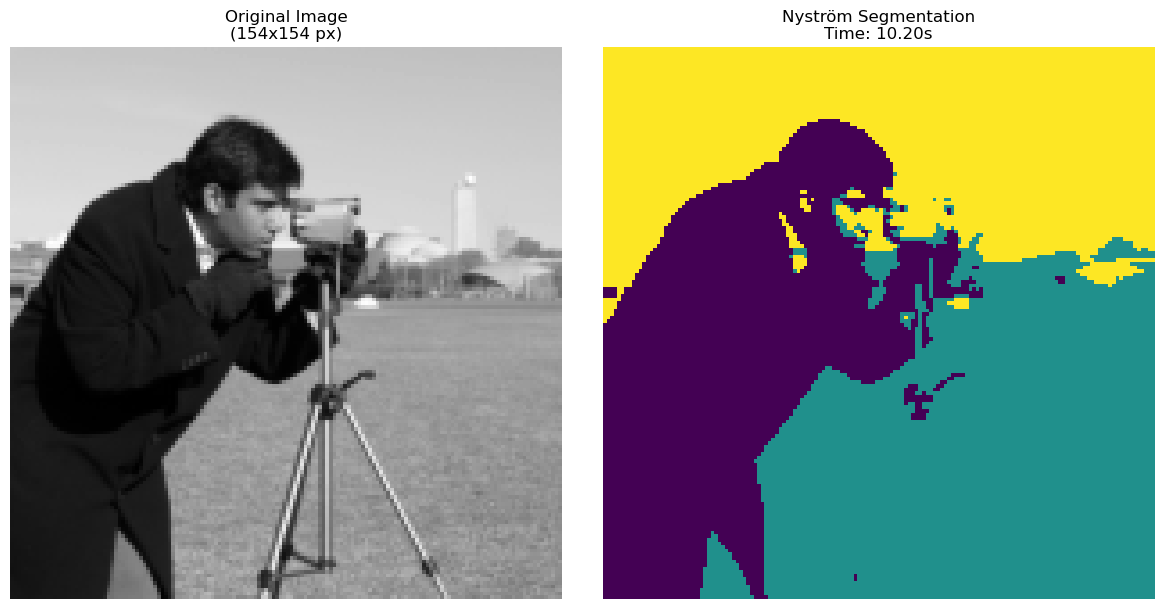

In [8]:
img = data.camera()

scale_factor = 0.30 
img_res = rescale(img, scale_factor, anti_aliasing=True)
rows, cols = img_res.shape
n_pixels = rows * cols

r_coords, c_coords = np.indices((rows, cols))
X_cam = np.column_stack([r_coords.ravel() * 150 , c_coords.ravel() * 150,img_res.ravel() * 300])
X_scaled = StandardScaler().fit_transform(X_cam)

start_n = time.time()
labels_nyst, _, _ = nystrom_spectral_clustering(X_scaled, m=500, n_clusters=3, gamma=6.0)
time_nyst = time.time() - start_n

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img_res, cmap='gray')
ax[0].set_title(f"Original Image\n({rows}x{cols} px)")
ax[0].axis('off')

ax[1].imshow(labels_nyst.reshape(rows, cols), cmap='viridis')
ax[1].set_title(f"Nyström Segmentation\nTime: {time_nyst:.2f}s")
ax[1].axis('off')

plt.tight_layout()
plt.show()


### Gamma fine-tuning functions

In [9]:
def gamma_best(X, n_clusters, gamma_candidates, m_test=300, silhouette_samples=1000):
    
    n_pixels = X.shape[0]
    results = []
    
    print(f"Starting Silhouette analysis on {len(gamma_candidates)} candidates:")
    for g in gamma_candidates:
        labels_tmp, _, _ = nystrom_spectral_clustering(X, m=m_test, n_clusters=n_clusters, gamma=g)
        
        sample_size = min(silhouette_samples, n_pixels)
        idx = np.random.choice(n_pixels, sample_size, replace=False)
        
        score = silhouette_score(X[idx], labels_tmp[idx])
        results.append({
            'gamma': g,
            'score': score,
            'labels': labels_tmp
        })
        print(f"  > Gamma {g:.2f} | Silhouette Score: {score:.4f}")
    
    
    best_res = max(results, key=lambda x: x['score'])
    worst_res =min(results, key=lambda x: x['score'])
    return best_res, worst_res, results

def plot_gamma_search(img_res, search_results):
    
    rows, cols = img_res.shape
    n_tests = len(search_results)
    fig, axes = plt.subplots(1, n_tests + 1, figsize=(4 * (n_tests + 1), 5))

    axes[0].imshow(img_res, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')

    for i, res in enumerate(search_results):
        axes[i+1].imshow(res['labels'].reshape(rows, cols), cmap='viridis')
        axes[i+1].set_title(f"Gamma: {res['gamma']}\nScore: {res['score']:.3f}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

### Gamma comparison on Image Segmentation

Starting Silhouette analysis on 4 candidates:
  > Gamma 1.00 | Silhouette Score: 0.4583
  > Gamma 5.00 | Silhouette Score: 0.4491
  > Gamma 10.00 | Silhouette Score: 0.4434
  > Gamma 15.00 | Silhouette Score: 0.2575
Best Gamma: 1.0 with Score: 0.4583
--- Benchmark Configuration: 32041 pixels ---
Estimated memory required for Dense Affinity Matrix: 7.65 GB
------------------------------------------------------------
[!] SKIPPING DENSE METHOD
Reason: Input size (32041 pixels) exceeds the safety threshold (20000).
Computing the full N x N matrix would require 7.65 GB of RAM.
------------------------------------------------------------

--- Nyström-Fowlkes Execution ---
 Nyström successfully completed in 16.81s


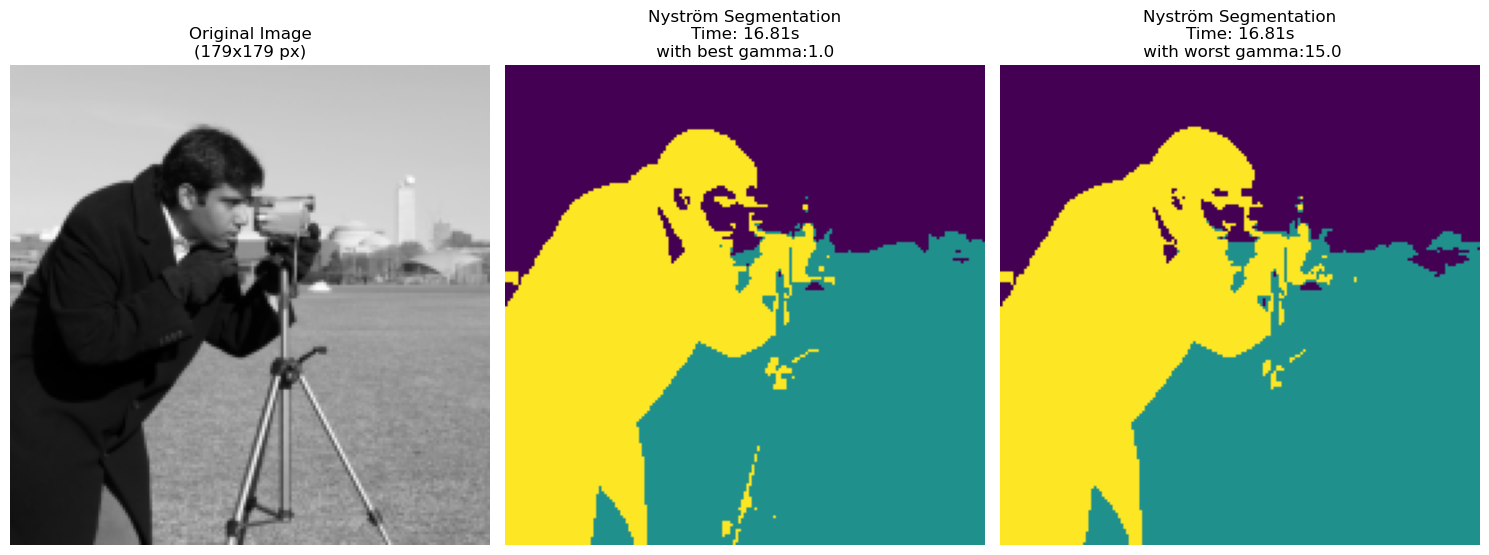

In [10]:
img = data.camera()
scale_factor = 0.35 
img_res = rescale(img, scale_factor, anti_aliasing=True)
rows, cols = img_res.shape
n_pixels = rows * cols

r_coords, c_coords = np.indices((rows, cols))
X_cam = np.column_stack([
    r_coords.ravel() * 150, 
    c_coords.ravel() * 150, 
    img_res.ravel() * 300
])

X_scaled = StandardScaler().fit_transform(X_cam)

search_sample_size = 10000
np.random.seed(42) 
idx_search = np.random.choice(n_pixels, min(search_sample_size, n_pixels), replace=False)
X_search = X_scaled[idx_search]

gamma_candidates = [1.0, 5.0, 10.0, 15.0]
best_result, worst_result, all_results = gamma_best(X_search, n_clusters=3, gamma_candidates=gamma_candidates)

print(f"Best Gamma: {best_result['gamma']} with Score: {best_result['score']:.4f}")

estimated_mem_gb = (n_pixels ** 2 * 8) / (1024**3)

print(f"--- Benchmark Configuration: {n_pixels} pixels ---")
print(f"Estimated memory required for Dense Affinity Matrix: {estimated_mem_gb:.2f} GB")

limit_pixel = 20000

if n_pixels > limit_pixel:
    print("-" * 60)
    print(f"[!] SKIPPING DENSE METHOD")
    print(f"Reason: Input size ({n_pixels} pixels) exceeds the safety threshold ({limit_pixel}).")
    print(f"Computing the full N x N matrix would require {estimated_mem_gb:.2f} GB of RAM.")
    print("-" * 60)
else:
    print(f"Starting Dense Spectral Clustering...")
    start_d = time.time()
    
    labels_dense = spectral_clustering(X_scaled, n_clusters=3, sigma=0.5,k_nn=10, plot_results=False) 
    elapsed = time.time() - start_d
    print(f"Dense clustering completed successfully in {elapsed:.4f}s")

print("\n--- Nyström-Fowlkes Execution ---")
start_n = time.time()

labels_nyst, _, _ = nystrom_spectral_clustering(X_scaled, m=500, n_clusters=3, gamma=best_result['gamma'])
time_nyst = time.time() - start_n
print(f" Nyström successfully completed in {time_nyst:.2f}s")
labels_worst, _, _ = nystrom_spectral_clustering(X_scaled, m=500, n_clusters=3, gamma=worst_result['gamma'])

fig, ax = plt.subplots(1, 3, figsize=(15, 6))

ax[0].imshow(img_res, cmap='gray')
ax[0].set_title(f"Original Image\n({rows}x{cols} px)")
ax[0].axis('off')

ax[1].imshow(labels_nyst.reshape(rows, cols), cmap='viridis')
ax[1].set_title(f"Nyström Segmentation\nTime: {time_nyst:.2f}s\n with best gamma:{best_result['gamma']} ")
ax[1].axis('off')

ax[2].imshow(labels_worst.reshape(rows, cols), cmap='viridis')
ax[2].set_title(f"Nyström Segmentation\nTime: {time_nyst:.2f}s\n with worst gamma:{worst_result['gamma']}")
ax[2].axis('off')


plt.tight_layout()
plt.show()